In [1]:
import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import torch
import anndata

Global seed set to 0


In [2]:
adata_rna_train = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_src_train_processed.h5ad")
adata_activity_train = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_activity_train_processed.h5ad")

In [3]:
adata_rna_train.layers["counts"] = adata_rna_train.layers["raw_counts"].copy()
adata_activity_train.layers["counts"] = adata_activity_train.X.copy()

In [4]:
adata_rna_train_copy = adata_rna_train[:, list(set(adata_activity_train.var_names).intersection(adata_rna_train.var_names))]
adata = anndata.concat((adata_rna_train_copy, adata_activity_train), label="batch")

In [5]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=1000,
    batch_key="batch",
    subset=True,
)

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [6]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

In [7]:
model = scvi.model.SCVI(adata)

In [ ]:
model.train(early_stopping=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/400:  75%|███████████████████████████████████████████████████████████                    | 299/400 [02:11<00:36,  2.74it/s, loss=772, v_num=1]

In [28]:
model_dir = os.path.join("lustre/groups/ml01/workspace/ot_perturbation/data/multiome", "scvi")
model.save(model_dir, overwrite=True)

In [29]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [30]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

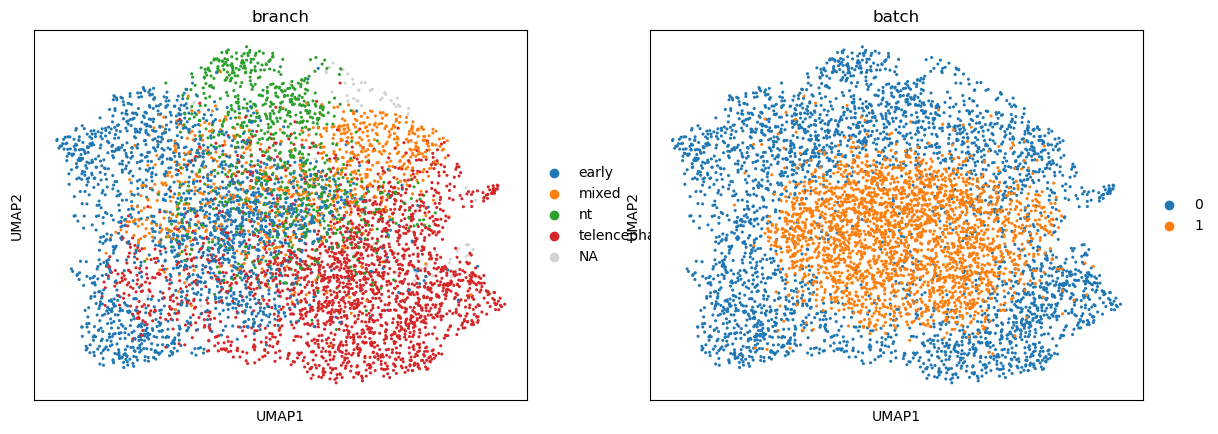

In [31]:
sc.pl.umap(adata, color=["branch", "batch"])

In [32]:
adata_rna_test = sc.read_h5ad("/home/icb/dominik.klein/tmp/GLI3_KO_multiome_18d_adata_src_test_processed.h5ad")
adata_activity_test = sc.read_h5ad("/home/icb/dominik.klein/tmp/GLI3_KO_multiome_18d_adata_activity_test_processed.h5ad")

In [33]:
adata_rna_test.obs["_scvi_batch"] = 0
adata_rna_test.obs["_scvi_labels"] = 0
adata_rna_test.obs["batch"] = "0"

In [34]:
adata_rna_test.layers["counts"] = adata_rna_test.layers["raw_counts"]

In [35]:
adata_rna_test = adata_rna_test[:, adata.var_names]

In [36]:
adata_rna_test.obsm[SCVI_LATENT_KEY] = model.get_latent_representation(adata_rna_test)

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/data/_utils.py:114: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [37]:
adata_activity_test.layers["counts"] = adata_activity_test.X.copy()
adata_activity_test = adata_rna_test[:, adata.var_names]

In [38]:
adata_activity_test.obsm[SCVI_LATENT_KEY] = model.get_latent_representation(adata_activity_test)

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/data/_utils.py:114: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [39]:
bdata = anndata.concat((adata_rna_test, adata_activity_test), label="batch")

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [40]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

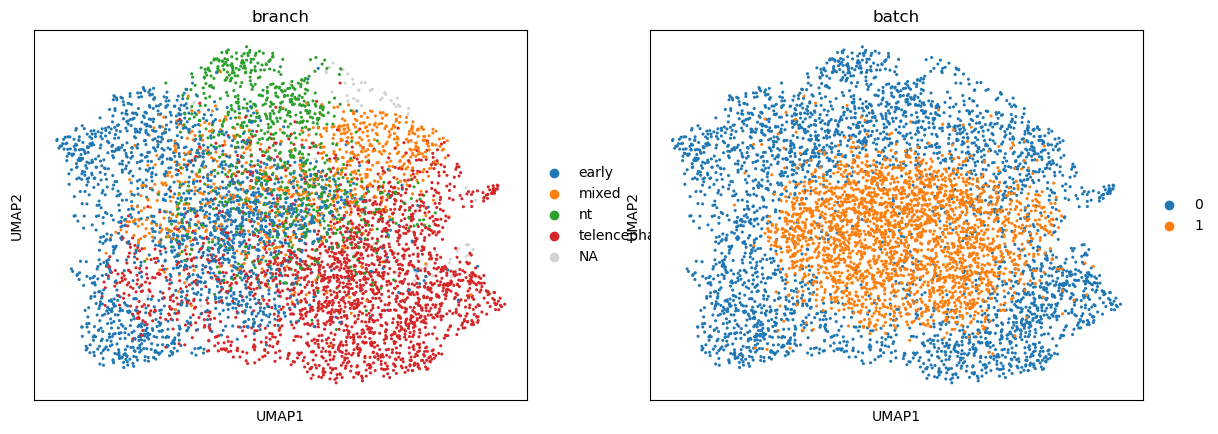

In [41]:
sc.pl.umap(adata, color=["branch", "batch"])

In [42]:
adata.obsm

AxisArrays with keys: X_scVI, X_umap

In [43]:
adata_rna_train.obsm["X_scVI"] = adata[adata_rna_train.obs_names].obsm["X_scVI"]
adata_activity_train.obsm["X_scVI"] = adata[adata_activity_train.obs_names].obsm["X_scVI"]

In [44]:
adata_rna_train.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_src_train_processed_with_scvi.h5ad")
adata_activity_train.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_activity_train_processed_with_scvi.h5ad")

In [45]:
adata_rna_test.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_src_test_processed_with_scvi.h5ad")
adata_activity_test.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_activity_test_processed_with_scvi.h5ad")